In [13]:
import os
from typing import List, Optional

import cv2
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [2]:
class VideoController(object):
    def __init__(self, movie_path: str):
        """Video Controller. this class has some useful method which get image from a video.

        Args:
            movie_path (str): movie file path

        Raises:
            FileNotFoundError: if file not found.
            ValueError: if file cannot be opened.
        """
        self.movie_path = movie_path
        if self.movie_path != 0 and not os.path.exists(movie_path):
            raise FileNotFoundError("camera or video cannot be opened.")

        self.video_capture = cv2.VideoCapture(movie_path)

        if not self.video_capture.isOpened():
            raise ValueError("camera or video cannot be opened.")

        self._frame_num = self.video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
        self._fps = self.video_capture.get(cv2.CAP_PROP_FPS)

    @property
    def fps(self) -> float:
        return self._fps

    @property
    def frame_num(self) -> int:
        return int(self._frame_num)

    @property
    def current_frame(self) -> float:
        return self.video_capture.get(cv2.CAP_PROP_POS_FRAMES)

    def get_current_image(self) -> npt.NDArray[np.uint8]:
        """get image at current index of video.

        Raises:
            ValueError: if image cannot be extracted.

        Returns:
            npt.NDArray[np.uint8]: image as numpy array (height, width. color).
        """
        ret, frame = self.video_capture.read()
        if frame is None:
            raise ValueError("cannot read frame.")
        return frame

    def get_image_at(self, frame_idx: int) -> npt.NDArray[np.uint8]:
        """get image at designated frame index.

        Args:
            frame_idx (int): frame index.

        Returns:
            npt.NDArray[np.uint8]: image as numpy array (height, width. color).
        """
        if 0 <= frame_idx - self.current_frame <= 10:
            im = np.array([], dtype="uint8")
            for _ in range(int(frame_idx - self.current_frame + 1)):
                im = self.get_current_image()
            return im

        self.video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        return self.get_current_image()

    def get_random_image(self) -> npt.NDArray[np.uint8]:
        frame_idx = np.random.random_integers(0, int(self.frame_num) - 1)
        return self.get_image_at(frame_idx=frame_idx)

    def __del__(self):
        if self.video_capture is not None:
            self.video_capture.release()


class VideoNotInitialized(Exception):
    pass


class VideoSaver:
    def __init__(
        self, video_path: str, fps=30.0, video_format: Optional[List[str]] = None
    ) -> None:
        """VideoSaver. A wrapper class of cv2.VideoWriter

        Args:
            video_path (str): video path for saving.
            fps (float, optional): fps. Defaults to 30.0.
            video_format (list): video format. default is ["m", "p", "4", "v"]

        """
        self._video_path: str = video_path
        self._video: Optional[cv2.VideoWriter] = None
        self._fps = fps
        self._video_format = video_format or ["m", "p", "4", "v"]
        self._frame_num = 0
        self._img_size_h = -1
        self._img_size_w = -1

    @property
    def video_path(self) -> str:
        return str(self._video_path)

    @property
    def fps(self) -> float:
        return float(self._fps)

    @property
    def frame_num(self) -> int:
        return int(self._frame_num)

    @property
    def image_size(self) -> tuple:
        if self._img_size_h == -1 or self._img_size_w == -1:
            raise VideoNotInitialized("not initialized yet. put image first.")
        return (self._img_size_h, self._img_size_w)

    def write(self, image: np.ndarray) -> None:
        """put image into a video.

        Args:
            image (np.ndarray): Shape is h x w x c and channel format is BGR.

        Raises:
            ValueError: raise Error if image size changed.
        """
        if self._video is None:
            img_size_w = image.shape[1]
            img_size_h = image.shape[0]
            self._img_size_h = img_size_h
            self._img_size_w = img_size_w

            fourcc = cv2.VideoWriter_fourcc(*self._video_format)
            os.makedirs(os.path.dirname(self._video_path), exist_ok=True)
            self._video = cv2.VideoWriter(
                self._video_path, fourcc, self._fps, (img_size_w, img_size_h)
            )
        if image.shape[1] != self._img_size_w or image.shape[0] != self._img_size_h:
            raise ValueError("all image size must be same.")
        self._video.write(image)
        self._frame_num += 1

    def __call__(self, image: np.ndarray) -> None:
        """put image into a video.

        Args:
            image (np.ndarray): Shape is h x w x c and channel format is BGR.
        """
        self.write(image)

    def release(self) -> None:
        """release video."""
        if self._video is not None:
            self._video.release()

    def __del__(self) -> None:
        self.release()

In [55]:
video_root  = '/storage/dataset/MEG/internal/AnnotatedMovie_v1/tmp/stim_video/'
movie_file_list = [
    'ID01_HerosVol1-1_id1_MEG_DATAPixx_part{part_id}.mp4',
    'ID02_TheMentalistVol1-1_id2_MEG_DATAPixx_part{part_id}.mp4',
    'ID03_GleeVol1-1_id3_MEG_DATAPixx_part{part_id}.mp4',
    'ID04_TheCrownVol1-1_id4_MEG_DATAPixx_part{part_id}.mp4',
    'ID05_SuitsVol1-1_id5_MEG_DATAPixx_part{part_id}.mp4',
    'ID06_TheBigBangTheoryVol1-1_id6_MEG_DATAPixx_part{part_id}.mp4',
    'ID07_TheBigBangTheoryVol1-2_id7_MEG_DATAPixx_part{part_id}.mp4',
    'ID08_DreamGirlsVol1-1_id8_MEG_DATAPixx_part{part_id}.mp4',
    'ID09_BreakingBadVol1-1_id9_MEG_DATAPixx_part{part_id}.mp4',
    'ID10_GhostInTheShellVol1-1_id10_MEG_DATAPixx_part{part_id}.mp4'
    
]
part_id = 1
movie_id = 1
video_path = os.path.join(video_root, movie_file_list[movie_id].format(part_id=part_id))
vc = VideoController(video_path)

In [4]:
video_capture = cv2.VideoCapture(video_path)

In [5]:
video_capture.isOpened()

True

28241
29.97002997002997
(1080, 1920, 3)


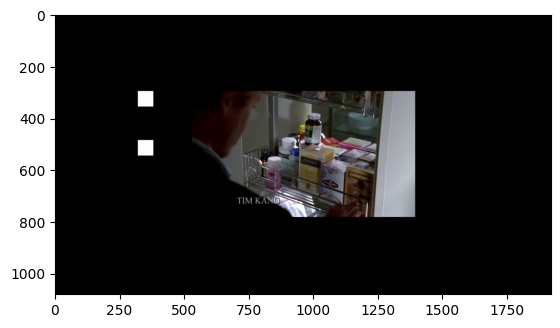

In [61]:
print(vc.frame_num)
print(vc.fps)
print(vc.get_image_at(4003).shape)
image = vc.get_current_image()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

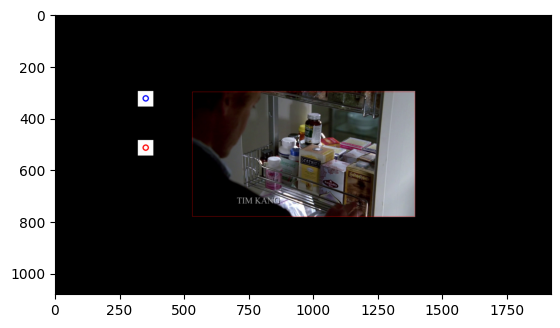

(530, 300) (1390, 780)


In [62]:
image_size = image.shape[0:2] # height x width
window_size = (480, 860) # height x width
slow_trigger_center= (325, 350) # height x width
fast_trigger_center= (515, 350) # height x width
hs = int((image_size[0] - window_size[0])/2)
ws = int((image_size[1] - window_size[1])/2)
image = cv2.rectangle(image,
              pt1=(ws, hs),
              pt2=(ws+window_size[1], hs+window_size[0]),thickness=1,color=(255,0,0))
cv2.circle(image, (fast_trigger_center[1], fast_trigger_center[0]), 10, (255,0,0), thickness=3, lineType=cv2.LINE_8, shift=0)
cv2.circle(image, (slow_trigger_center[1], slow_trigger_center[0]), 10, (0,0,255), thickness=3, lineType=cv2.LINE_8, shift=0)
plt.imshow(image)
plt.show()
print((ws, hs), (ws+window_size[1], hs+window_size[0]))

20388
25.0
(1080, 1920, 3)
[[ 98  98  98  98  98  98 101 102  98  98]
 [107 107 107 107 107 107 105 106 108 108]
 [107 107 107 108 108 108 105 106 109 108]
 [105 105 105 105 108 108 107 107 107 106]
 [105 105 105 105 108 108 106 107 107 105]
 [107 107 105 105 109 109 105 106 109 107]
 [107 108 106 105 111 109 105 106 108 108]
 [107 107 105 105 109 107 105 105 108 108]
 [109 109 105 106 106 107 105 105 108 108]
 [109 109 106 105 105 106 105 105 106 106]]


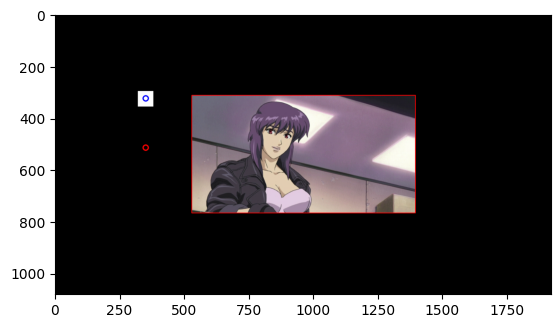

(528, 313) (1392, 767)


In [177]:
video_root  = '/storage/dataset/MEG/internal/AnnotatedMovie_v1/tmp/stim_video/'
movie_file_list = [
    'ID01_HerosVol1-1_id1_MEG_DATAPixx_part{part_id}.mp4',
    'ID02_TheMentalistVol1-1_id2_MEG_DATAPixx_part{part_id}.mp4',
    'ID03_GleeVol1-1_id3_MEG_DATAPixx_part{part_id}.mp4',
    'ID04_TheCrownVol1-1_id4_MEG_DATAPixx_part{part_id}.mp4',
    'ID05_SuitsVol1-1_id5_MEG_DATAPixx_part{part_id}.mp4',
    'ID06_TheBigBangTheoryVol1-1_id6_MEG_DATAPixx_part{part_id}.mp4',
    'ID07_TheBigBangTheoryVol1-2_id7_MEG_DATAPixx_part{part_id}.mp4',
    'ID08_DreamGirlsVol1-1_id8_MEG_DATAPixx_part{part_id}.mp4',
    'ID09_BreakingBadVol1-1_id9_MEG_DATAPixx_part{part_id}.mp4',
    'ID10_GhostInTheShellVol1-1_id10_MEG_DATAPixx_part{part_id}.mp4'
    
]
part_id = 1
movie_id = 9
video_path = os.path.join(video_root, movie_file_list[movie_id].format(part_id=part_id))
vc = VideoController(video_path)

print(vc.frame_num)
print(vc.fps)
print(vc.get_image_at(20000).shape)
image = vc.get_current_image()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_size = image.shape[0:2] # height x width
window_size = (454, 864)# (486, 864)# 9(456, 864)# 7((380, 864) # 3(440, 860) # height x width
slow_trigger_center= (325, 350) # height x width
fast_trigger_center= (515, 350) # height x width
hs = int((image_size[0] - window_size[0])/2)
ws = int((image_size[1] - window_size[1])/2)
print(image[hs:hs+window_size[0], ws:ws+window_size[1]][:10,:10, 0])

image = cv2.rectangle(image,
              pt1=(ws, hs),
              pt2=(ws+window_size[1], hs+window_size[0]),thickness=2,color=(255,0,0))
cv2.circle(image, (fast_trigger_center[1], fast_trigger_center[0]), 10, (255,0,0), thickness=3, lineType=cv2.LINE_8, shift=0)
cv2.circle(image, (slow_trigger_center[1], slow_trigger_center[0]), 10, (0,0,255), thickness=3, lineType=cv2.LINE_8, shift=0)
plt.imshow(image)
plt.show()
print((ws, hs), (ws+window_size[1], hs+window_size[0]))
